<a href="https://colab.research.google.com/github/shravs45/Machine-Learning/blob/NLP/Predict_Product_Category.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import time
import datetime

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier 

from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import plot_confusion_matrix

from itertools import cycle

import warnings
warnings.filterwarnings('ignore')

In [ ]:
def load_data(filepath):
  df = pd.read_csv(filepath)  
  return df

In [ ]:
def clean_text(text):
  #remove xx sequence
  text=text.lower()
  text=re.sub('xx','',text)
  #remove Special Characters
  text=re.sub('[^0-9a-z ]','',text)
  #remove digits
  text=re.sub('[\d]*','',text)
  return text.strip()



In [ ]:
#using tf idf vectorizer
def vectors(text):
  vectorizer = TfidfVectorizer(min_df=3,
                               max_df=0.9,
                              ngram_range= (1,2), 
                              stop_words ='english',
                              token_pattern=r'\w{4,}')
  X = vectorizer.fit_transform(text)
  return X,vectorizer

In [ ]:
def Encode(column_values):
  labelencoder=LabelEncoder()
  labelencoder.fit(column_values.unique())
  y=labelencoder.transform(column_values)
  return y

In [ ]:
train_df=load_data('/content/drive/MyDrive/Colab Notebooks/Project 1/Edureka_Consumer_Complaints_train.csv')
test_df=load_data('/content/drive/MyDrive/Colab Notebooks/Project 1/Edureka_Consumer_Complaints_test.csv')

In [ ]:
#To check availability of Null values in each Column 
train_df.isnull().sum()

Date received                        0
Product                              0
Sub-product                     103786
Issue                                0
Sub-issue                       219374
Consumer complaint narrative    302630
Company public response         290879
Company                              0
State                             2903
ZIP code                          2911
Tags                            308584
Consumer consent provided?      257230
Submitted via                        0
Date sent to company                 0
Company response to consumer         0
Timely response?                     0
Consumer disputed?                   0
Complaint ID                         0
dtype: int64

In [ ]:
# To check What percentage of Issues are disputed and nondisputed.
No_disputes_count= train_df[train_df['Consumer disputed?']=='No']['Product'].count()
disputed_count=train_df[train_df['Consumer disputed?']=='Yes']['Product'].count()
print("Disputed Count:{}, Not disputed Count:{}".format(disputed_count,No_disputes_count))

Disputed Count:76172, Not disputed Count:282638


* **21%** - **disputed Issues**<br>
* **79%** - Not disputed Issues

# **1. ANALYSING THE MISSING VALUES**

In [ ]:
d={}
#Find out What percentage of values are missing in Each column.
print("Percentage of Missing values in Each column")
for i in train_df.columns:
  if train_df[i].isnull().sum()>0:
    d[i]=(train_df[i].isnull().sum()/train_df.shape[0])*100
#"{:.2f}".format((

sorted(d.items(), key=lambda x: x[1], reverse=True)

Percentage of Missing values in Each column


[('Company public response', 81.06769599509491),
 ('Sub-issue', 61.13932164655389),
 ('Sub-product', 28.925057830049326),
 ('ZIP code', 0.8112928848136898),
 ('State', 0.8090632925503749)]

* In the above Statistical Analysis, **State and Zipcode** columns have  less than 1% of Null Values. So ignoring those 2 columns for Missing Value Analysis.
* **Sub-Product** and **Sub-issue** column are not missed at random(MAR). Because, these Column values are based on Product column. So, ignoring these 2 columns, as it will mislead the analysis.
*   Overall 86% of values are missing in **Tags** column. So, dropping the Tags column as it wont contribute much to Predict dispute.<br>
*   Though **Consumer Complaint Narrative** column is also missing 80% of values, cannot be dropped because we need to use that column to predict Product Category
*   Next highest missing Values are in Company Public Response and Consumer consent provided columns. 
*   We may need to check how the company responds to Issue. So retaining Company Public Response column.
*   We need to check is there any relation between consumer disputes vs consumer consent provided.

In [ ]:
#dropping Tags column
train_df.drop(['Tags'],axis=1,inplace=True)
train_df.shape

(358810, 17)

# Additional Check

In [ ]:
print("Percentage of Null values in Each column for Each Product")
products=train_df['Product'].unique()
for name in products:
  print("***********",name,"*************************")
  df=train_df[train_df['Product']==name]
  for col in df.columns:
    if df[col].isnull().sum()>0:
      print(col,":","{:.2f}".format((df[col].isnull().sum()/df.shape[0])*100,),"%")
  print("**************END**************************")

Percentage of Null values in Each column for Each Product
*********** Credit reporting *************************
Sub-product : 100.00 %
Company public response : 69.39 %
State : 0.48 %
ZIP code : 0.48 %
**************END**************************
*********** Bank account or service *************************
Sub-issue : 100.00 %
Company public response : 79.85 %
State : 1.88 %
ZIP code : 1.89 %
**************END**************************
*********** Credit card *************************
Sub-product : 100.00 %
Sub-issue : 100.00 %
Company public response : 83.93 %
State : 0.88 %
ZIP code : 0.88 %
**************END**************************
*********** Debt collection *************************
Company public response : 79.43 %
State : 0.61 %
ZIP code : 0.62 %
**************END**************************
*********** Mortgage *************************
Sub-issue : 100.00 %
Company public response : 86.50 %
State : 0.67 %
ZIP code : 0.67 %
**************END**************************
**********

# Missing Data Pattern for each Product

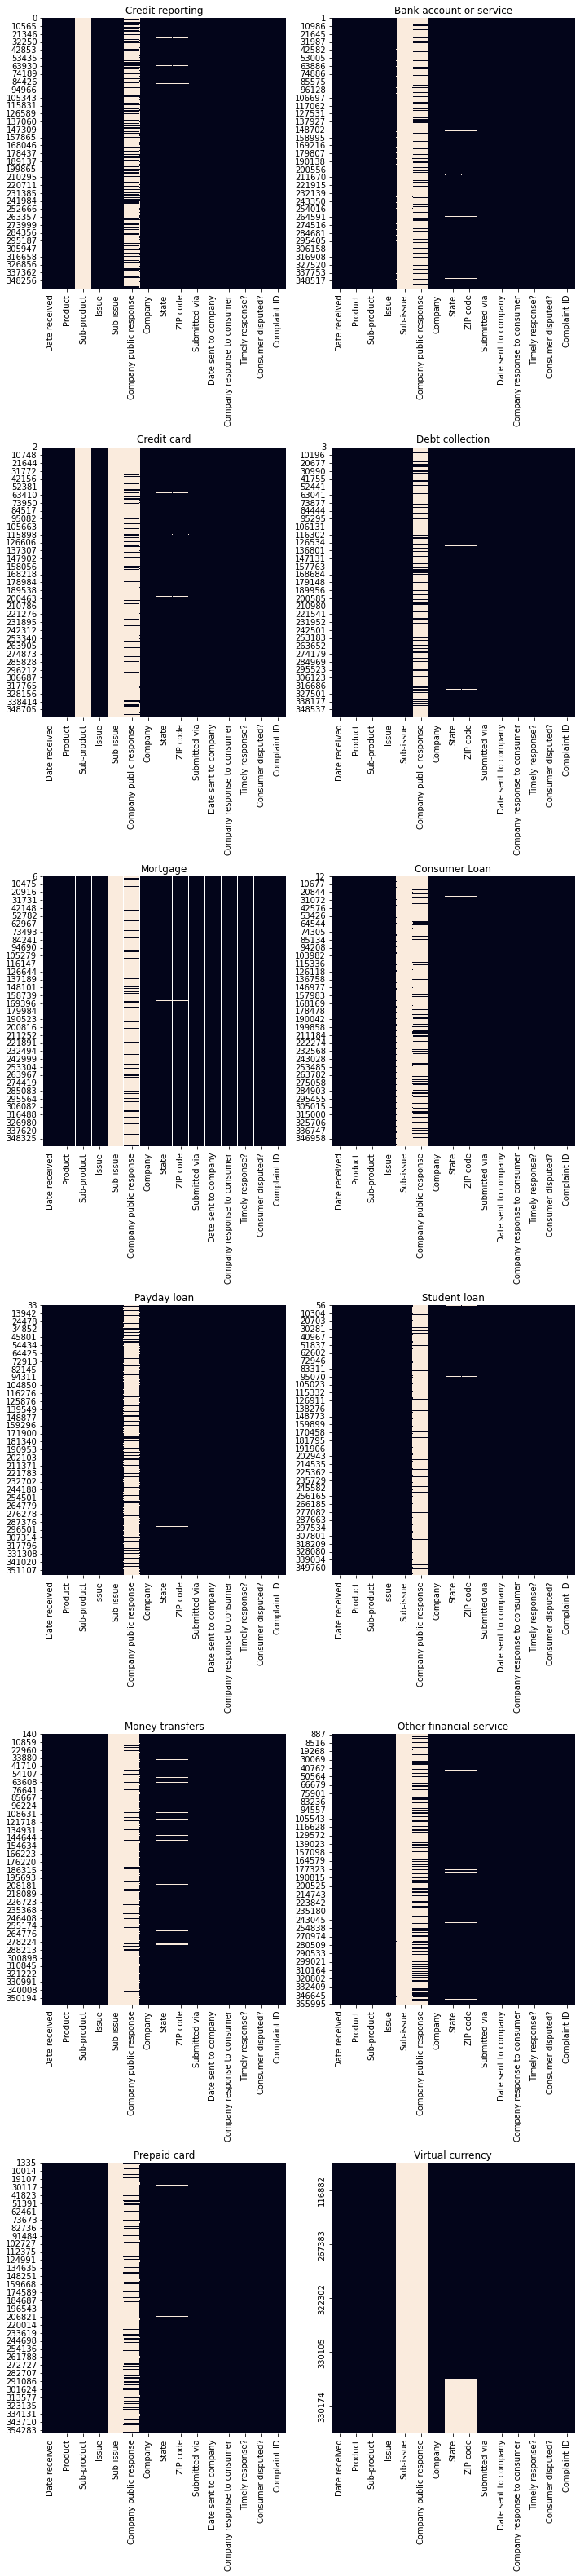

In [ ]:
#Analysing the missing data pattern for Each Product
fig, ax = plt.subplots(nrows=6, ncols=2,figsize=(10,44))
r=0
c=0
for i,name in enumerate(train_df['Product'].unique()):
  if i==2 or i==4 or i==6 or i==8 or i==10:
    r=r+1
    c=0
  df=train_df[train_df['Product']==name]
  ax[r][c].set_title(name)
  sns.heatmap(df.isnull(),cbar=False,ax=ax[r][c])
  c=c+1
  
plt.tight_layout()


**SubProduct**, **SubIssue** column values are missing wrt product category. 
So, Imputation of Missing values need to do wrt Product category

**Sub Issue Column:** - 100% Null Value for below Product Categories
1.   Bank Account or Service
2.   Credit card
3.   Mortgage
4.   Consumerloan
5.   Money Transfers
6.   Other financial Service
7.   Prepaid card
8.   List item
9.   Virtual Currency

**Sub Product column:** - 100% Null value for below categories<br>
1.  Credit Reporting<br>
2.  credit card



# **2. Number of unique values & most frequently occurring values in the Categorical Columns?**

In [ ]:
catcol_analysis_df=pd.DataFrame({'Categorical Column Names':[],'Unique Value Counts':[],'Frequently Occured Value':[]})

catcollist=[]
un_val_counts=[]
Fre_value=[]
for name in list(train_df):
  if 'Date' not in name and train_df[name].dtypes==object and "ZIP" not in name:
     catcollist.append(name)
     un_val_counts.append(len(train_df[name].unique()))
     Fre_value.append(train_df[name].mode()[0])
catcol_analysis_df['Categorical Column Names']=catcollist
catcol_analysis_df['Unique Value Counts']=un_val_counts
catcol_analysis_df['Frequently Occured Value']=Fre_value
catcol_analysis_df

,Categorical Column Names,Unique Value Counts,Frequently Occured Value
0,Product,12,Mortgage
1,Sub-product,48,Other mortgage
2,Issue,95,"Loan modification,collection,foreclosure"
3,Sub-issue,68,Account status
4,Company public response,11,Company chooses not to provide a public response
5,Company,3064,Bank of America
6,State,63,CA
7,Submitted via,6,Web
8,Company response to consumer,6,Closed with explanation
9,Timely response?,2,Yes


Most Frequent **Issue** is *"Loan, modification, foreclosure"*<br>
Here Most Frequent SubIssue shows *"Account Status"* which doesnt belong to this "Loan, modification, foreclosure" issue category.

It's misleading when we check most frequent values for Subproduct and SubIssue altogether. Even for Consumer Complaint Narrative, fetched complaint belongs to other category not the Mortgage category.

**Most frequently occured value for each Product Category in Categorical Columns**


---






In [ ]:
colns=['Product','Issue','Consumer complaint narrative','Company public response','Company','State','Submitted via','Company response to consumer','Timely response?','Consumer disputed?']
product_vice_freq_values_df=pd.DataFrame(columns=colns)
products=train_df['Product'].unique()
for name in products:
  df=train_df[train_df['Product']==name]
  
  product_vice_freq_values_df = product_vice_freq_values_df.append({colns[0] : name, 
                                                                    colns[1] : df[colns[1]].mode()[0], 
                                                                    colns[2] : df[colns[2]].mode()[0],
                                                                    colns[3] : df[colns[3]].mode(),
                                                                    colns[4] : df[colns[4]].mode()[0],
                                                                    colns[5] : df[colns[5]].mode()[0],
                                                                    colns[6] : df[colns[6]].mode()[0],
                                                                    colns[7] : df[colns[7]].mode()[0],
                                                                    colns[8] : df[colns[8]].mode()[0],
                                                                    colns[9] : df[colns[9]].mode()[0]}, 
                ignore_index = True)


product_vice_freq_values_df


,Product,Issue,Consumer complaint narrative,Company public response,Company,State,Submitted via,Company response to consumer,Timely response?,Consumer disputed?
0,Credit reporting,Incorrect information on credit report,I have sent several requests to Experian reque...,0 Company chooses not to provide a public r...,Equifax,CA,Web,Closed with explanation,Yes,No
1,Bank account or service,"Account opening, closing, or management","On at least XXXX previous occasions, I request...",0 Company chooses not to provide a public r...,Bank of America,CA,Web,Closed with explanation,Yes,No
2,Credit card,Billing disputes,I have had my bank of america credit card endi...,0 Company chooses not to provide a public r...,Citibank,CA,Web,Closed with explanation,Yes,No
3,Debt collection,Cont'd attempts collect debt not owed,This company continues to report on my credit ...,0 Company believes it acted appropriately a...,Encore Capital Group,CA,Web,Closed with explanation,Yes,No
4,Mortgage,"Loan modification,collection,foreclosure",The response is fraudulent because I XXXX XXXX...,0 Company chooses not to provide a public r...,Bank of America,CA,Web,Closed with explanation,Yes,No
5,Consumer Loan,Managing the loan or lease,I applied for credit with XXXX XXXX expecting ...,0 Company chooses not to provide a public r...,Wells Fargo & Company,CA,Web,Closed with explanation,Yes,No
6,Payday loan,Charged fees or interest I didn't expect,94 % interest rate since XXXX I have paid {$44...,0 Company believes it acted appropriately a...,"Enova International, Inc.",CA,Web,Closed with explanation,Yes,No
7,Student loan,Dealing with my lender or servicer,I received my degree from University XXXX XXXX...,0 Company believes it acted appropriately a...,"Navient Solutions, Inc.",CA,Web,Closed with explanation,Yes,No
8,Money transfers,Fraud or scam,( GW stands for Google Wallet ) I am missing {...,0 Company chooses not to provide a public r...,The Western Union Company,CA,Web,Closed with explanation,Yes,No
9,Other financial service,Customer service/Customer relations,I visited XXXX # XXXX on XXXX/XXXX/15 I wrote ...,0 Company chooses not to provide a public r...,Bank of America,CA,Web,Closed with explanation,Yes,No


# 3. Can you identify the top issues raised by consumers in this dataset?

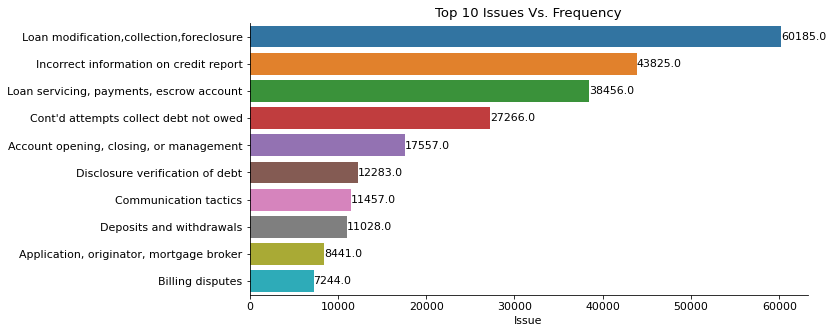

In [ ]:
top_issues=train_df['Issue'].value_counts()[0:10]
#sns.set_theme()
rc = {'figure.figsize':(10,5),
      'axes.facecolor':'white',
      'axes.grid' : False,
      'grid.color': '.8',
      'font.family':'Sans',
      'font.size' : 11}
plt.rcParams.update(rc)
plots=sns.barplot(x=top_issues,y=top_issues.index,orient='h')
plt.title('Top 10 Issues Vs. Frequency')
sns.despine()
for bar in plots.patches:
  plots.annotate(bar.get_width(),xy=(0+bar.get_width(),bar.get_y()+(bar.get_height()/2)),va='center')
plt.show()


# 4. Are there some products which receive a higher number of complaints?

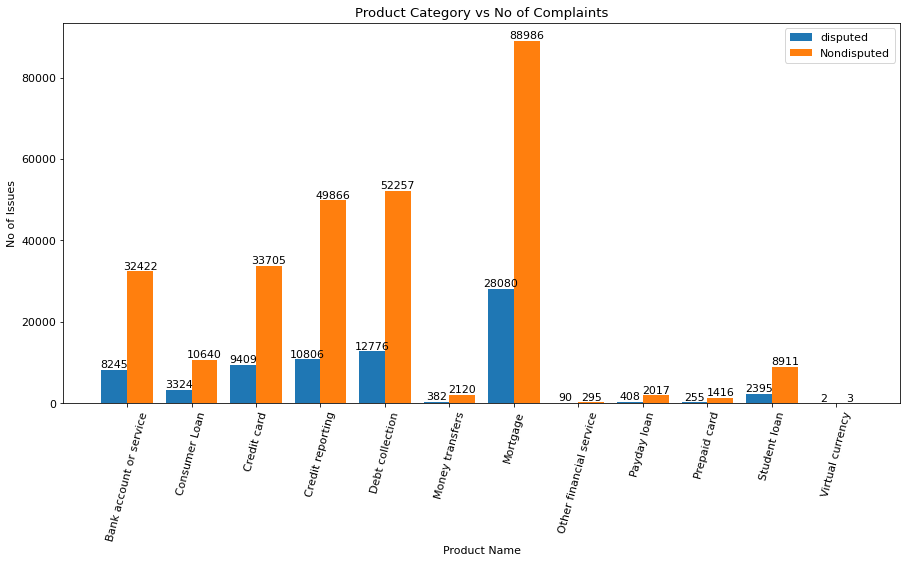

In [ ]:
#To Check What Percentage of Issues disputed Product vice

# disputed Product Category vs Issue Count
disputed_df=train_df[train_df['Consumer disputed?']=='Yes'].groupby('Product')['Product'].count()
# Nondisputed Product Category vs Issue Count
nondisputed_df=train_df[train_df['Consumer disputed?']=='No'].groupby('Product')['Product'].count()

#Product Names
X=list(disputed_df.index)

#To set location in X-axis
r=np.arange(len(X))

#bar plot to visualize No. of disputed and not disputed Issues for Each Product.
plt.figure(figsize=(15,7))
obj1=plt.bar(r,disputed_df.values,label='disputed',width=0.4)
obj2=plt.bar(r+0.4,nondisputed_df.values,label='Nondisputed',width=0.4)
plt.xticks(r+0.2,X,rotation=75)
for i in obj1.patches:
  plt.annotate(i.get_height(),xy=(i.get_x()+i.get_width()/2,i.get_height()),ha='center',va='bottom')
for i in obj2.patches:
  plt.annotate(i.get_height(),xy=(i.get_x()+i.get_width()/2,i.get_height()),ha='center',va='bottom')
plt.legend()
plt.xlabel("Product Name")
plt.ylabel("No of Issues")
plt.title("Product Category vs No of Complaints")
plt.show()

**Mortgage**, **Debt Collection**, **Credit Reporting**, **Credit Card** receive more complaints comparitively

*Statistics of Product Category vs Percentage of Complaints<br>*

*   32% - **Mortgage**. 24% - Not disputed. **8% - disputed**<br>
*   18% - **Debt Collection**. 14% - Not disputed. **4% - disputed** <br>
*   16% - **Credit Reporting**. 13% - Not disputed. **3% - disputed**<br> 
*   12% - **Credit Card**. 9% - Not disputed **3 - disputed**<br>
*   11% - **Bank Account or Service**. 9% - Not disputed **2% - disputed**<br>
*   4%  - **Consumer Loan**. 3% - Not disputed **1% - disputed**<br>
*   3%  - **Student Loan** <br>
*   Less than 1% Issues in *Money Transfers, Payday Loan, Prepaid Card, Other Financial Service, Virtual Currency*,  <br>














# 5. Do all the companies receive the same number of complaints?

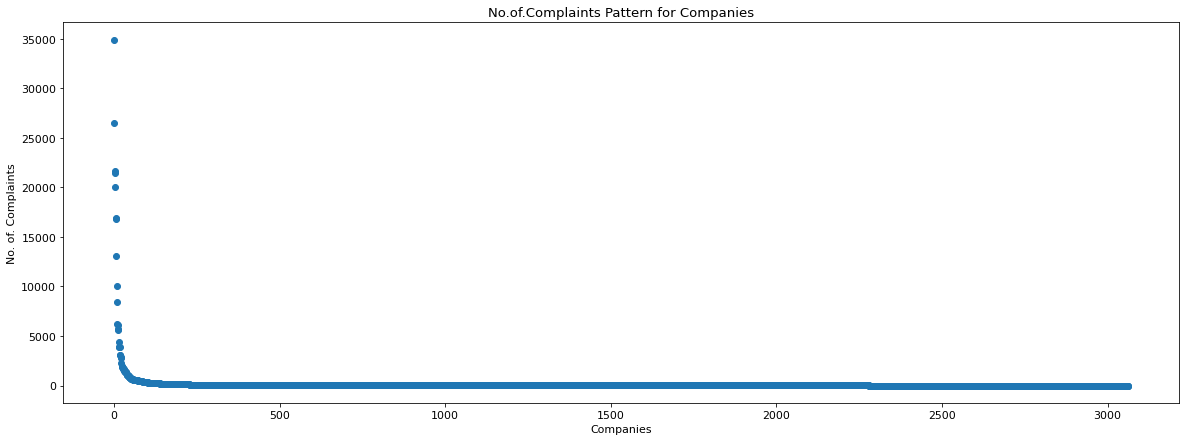

In [ ]:
d=train_df['Company'].value_counts()
bar=np.arange(len(d))
plt.figure(figsize=(20,7))
plt.scatter(bar,d.values)
plt.xlabel('Companies')
plt.ylabel('No. of. Complaints')
plt.title('No.of.Complaints Pattern for Companies')
plt.show()


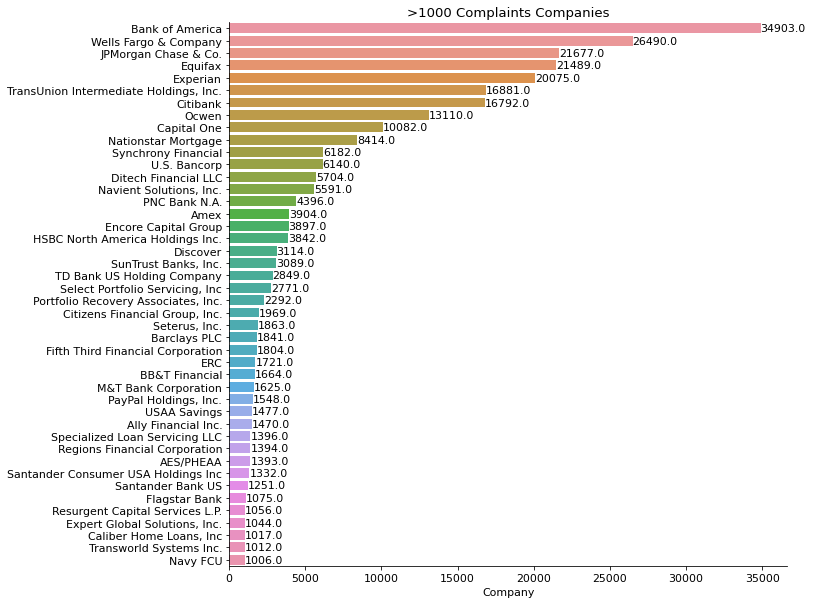

In [ ]:
#Complaints above 1000
g=train_df.groupby('Company')
top_companies = g.filter(lambda x: len(x) > 1000)['Company'].value_counts()

rc = {'figure.figsize':(10,10),
      'axes.facecolor':'white',
      'axes.grid' : False,
      'grid.color': '.8',
      'font.family':'Times New Roman',
      'font.size' : 11}
plt.rcParams.update(rc)
plots=sns.barplot(x=top_companies,y=top_companies.index,orient='h')
plt.title('>1000 Complaints Companies')
sns.despine()
for bar in plots.patches:
  plots.annotate(bar.get_width(),xy=(0+bar.get_width(),bar.get_y()+(bar.get_height()/2)),va='center')
plt.show()

In [ ]:
g=train_df.groupby('Company')
print(len(g.filter(lambda x: len(x) < 101)['Company'].value_counts()))
print(len(g.filter(lambda x: len(x) > 100 and len(x)<=1000)['Company'].value_counts()))
print(len(g.filter(lambda x: len(x) > 1000)['Company'].value_counts()))

* 2833 Companies : Less than 100 complaints <br> 
* 187 Companies  : greater than 100 and Less than 1000 companies<br>
* 44 Companies   : greater than 1000 Complaints

# 6. How are the complaints submitted - through which medium?


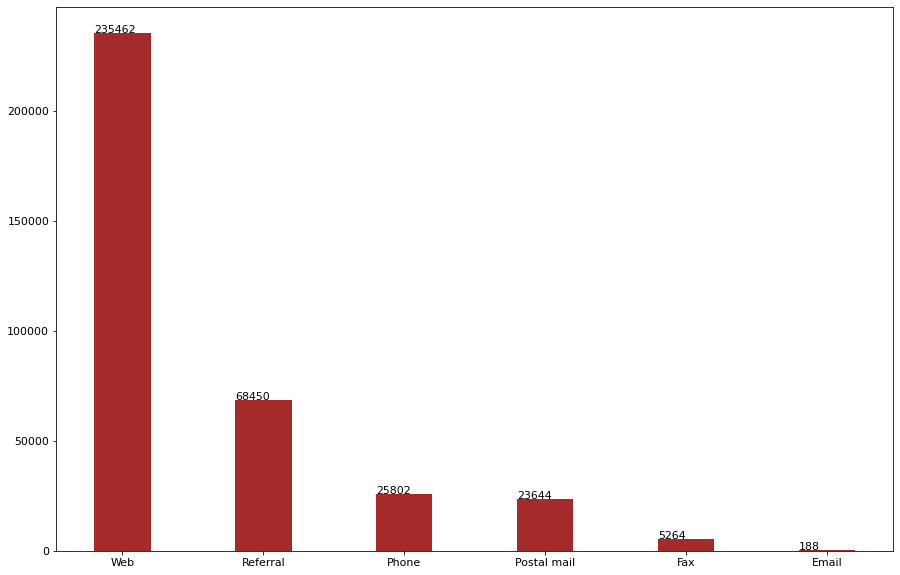

In [ ]:
medium_df=train_df['Submitted via'].value_counts()
medium_df
plt.figure(figsize=(15,10))
x=np.arange(len(medium_df))
obj=plt.bar(x,medium_df,width=0.4,color='brown')
plt.xticks(x,medium_df.index)
for i in obj.patches:
  plt.annotate(i.get_height(),xy=(i.get_x(),i.get_height()))
plt.show()

# 7. What is the geographical distribution of the complaints?

CA    52368
FL    34567
TX    26683
NY    24554
GA    15886
      ...  
MH       19
MP       13
AS        9
PW        8
AA        7
Name: State, Length: 62, dtype: int64


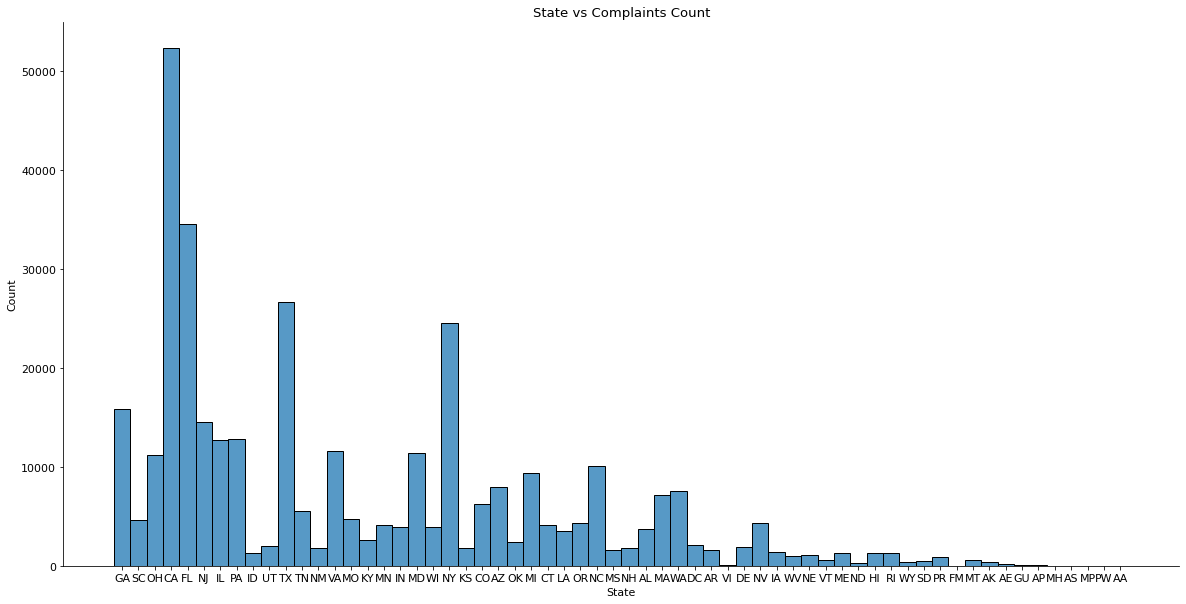

In [ ]:
geo=train_df['State'].value_counts()
#b=np.arange(len(geo))
#plt.scatter(b,y=geo.values)
#plt.show()
plt.figure(figsize=(20,10))
sns.histplot(data=train_df,x='State',bins=10)
sns.despine()
plt.title('State vs Complaints Count')
print(geo)

Skewness is observed. 

CA, FL states received 15% complaints<br>



# 8. Do the complaints rise in any specific month or day of the week?

In [ ]:
datetime.datetime.today().weekday()
train_df['Year']=train_df['Date received'].apply(lambda x: int(x.split('-')[0]))
train_df['Month']=train_df['Date received'].apply(lambda x: int(x.split('-')[1]))
train_df['Day_of_week']=train_df['Date received'].apply(lambda x: (datetime.datetime(int(x.split('-')[0]),int(x.split('-')[1]),int(x.split('-')[2])).weekday()))
train_df.drop('Date received',inplace=True,axis=1)

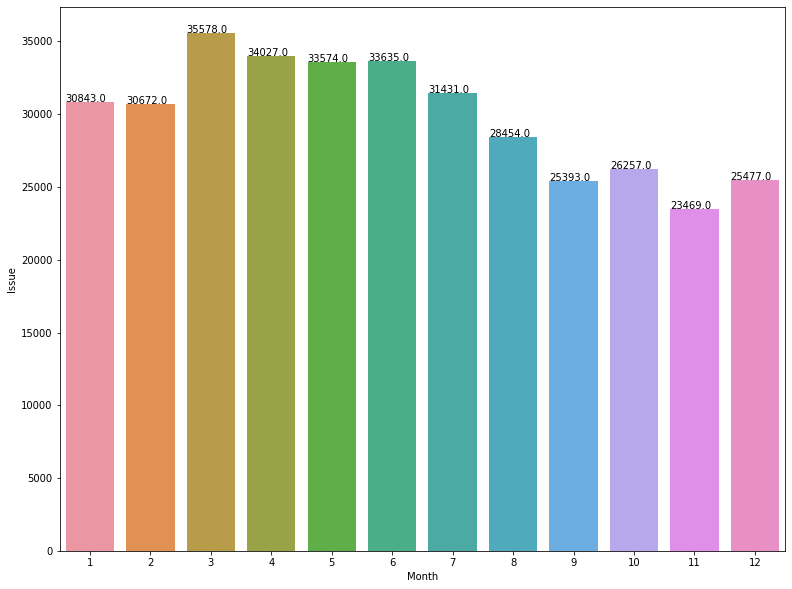

In [ ]:
# Issue distribution Month vice
df=train_df.groupby('Month')['Issue'].count()
df=df.reset_index()
r=np.arange(len(df['Month']))
plt.figure(figsize=(13,10))

obj=sns.barplot(data=df,x=df['Month'],y=df['Issue'])
for i in obj.patches:
  plt.annotate(i.get_height(),xy=(i.get_x(),(i.get_height()+i.get_width()/2)))
plt.show()

From the above Figure, its clear that more issues occured in **March**  comparitively.

**March - July**-> More Issues compatively

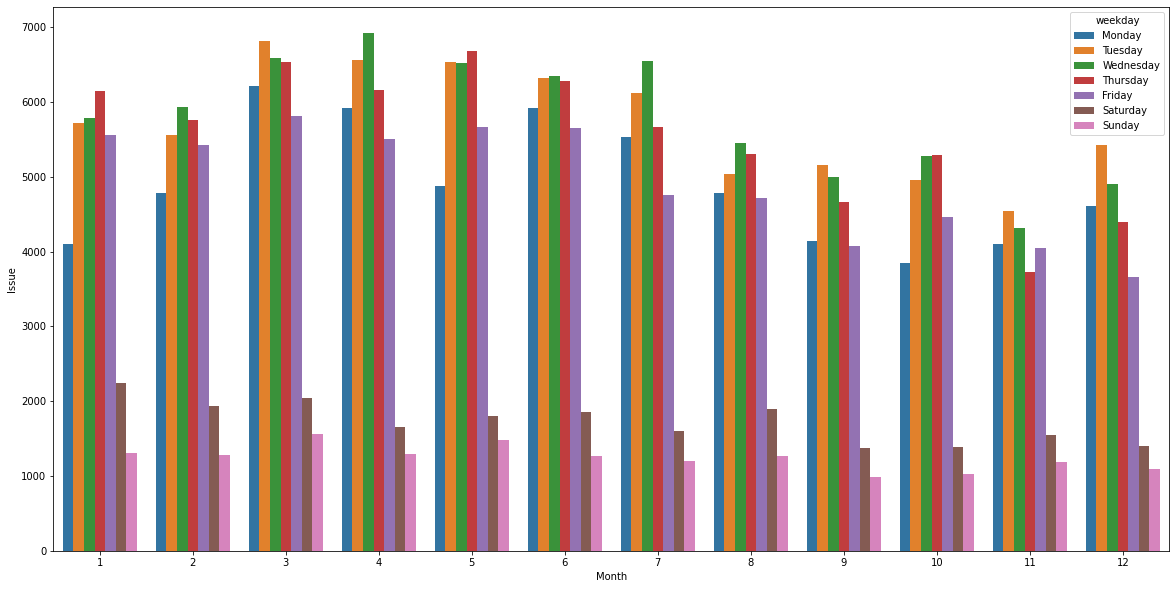

In [ ]:
# Issue distribution week vice
df=train_df.groupby(['Month','Day_of_week'])['Issue'].count()
df=df.reset_index()
plt.figure(figsize=(20,10))
df=df.sort_values('Issue')

labels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
df["weekday"] = df["Day_of_week"].map(dict(zip(range(0,7), labels)))
sns.barplot(data=df,x=df['Month'],y=df['Issue'],hue='weekday',hue_order=labels)
#plt.legend(labels=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])
plt.show()

* **Tuesday, Wednesday, Thursday** => Issue Count raises

## 9. How do companies respond to the complaints? What are the most common responses received?


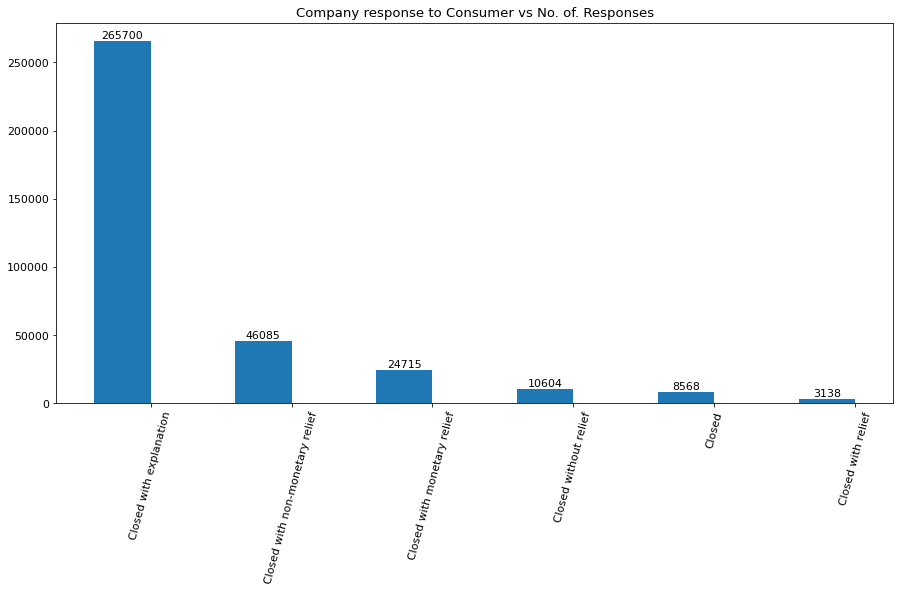

In [ ]:
c=train_df['Company response to consumer'].value_counts()
r=np.arange(len(c))

#bar plot to visualize No. of disputed and not disputed Issues for Each Product.
plt.figure(figsize=(15,7))
obj1=plt.bar(r,c.values,width=0.4)
plt.xticks(r+0.2,c.index,rotation=75)
for i in obj1.patches:
  plt.annotate(i.get_height(),xy=(i.get_x()+i.get_width()/2,i.get_height()),ha='center',va='bottom')
plt.title("Company response to Consumer vs No. of. Responses")
plt.show()

# 10. Does responding to complaints in a timely manner alter the number of consumers that disputed the company response and those that did not?


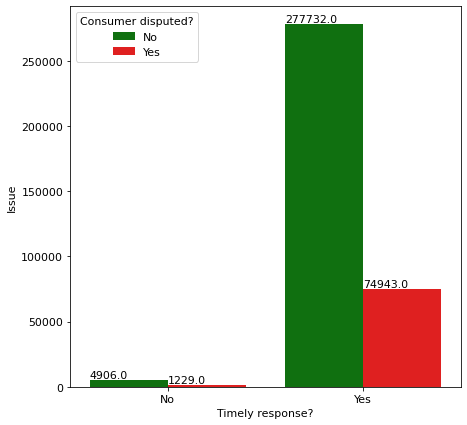

In [ ]:
df=train_df.groupby(['Timely response?','Consumer disputed?'])['Issue'].count()
df=df.reset_index()
plt.figure(figsize=(7,7))
obj=sns.barplot(data=df,x='Timely response?',y='Issue',hue='Consumer disputed?',palette={'No':'green','Yes':'red'})
for bar in obj.patches:
  plt.annotate(bar.get_height(),xy=(bar.get_x(),bar.get_height()+(bar.get_width()/2)),va='bottom')

**Description**:
disputed issue count: 76172

*   74943 - Timely Response
*   1229  - Delayed Response

Among overall disputed count, inspite of Timely Response,  99% of issues are disputed.

***So Timely Response doesn't alter the number of disputed issues***





# Part 2 - TEXT BASED MODELLING


**1.** **Dataset Description:**
      Predicting Product Category based on Consumer Complaint Narrative text. There are 358801 issues occured for 12 different Product Categories like Credit Report, Bank Account or Service, Mortgage etc.

In [ ]:
text_modelling_df=train_df[['Consumer complaint narrative', 'Product']]
print("train data",text_modelling_df.shape)

train data (358810, 2)


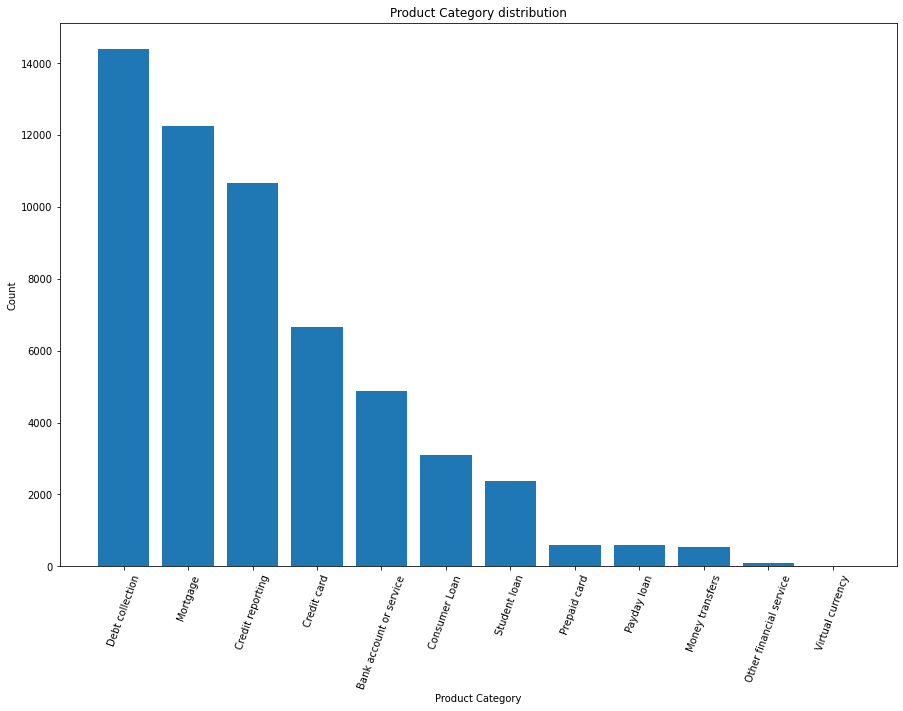

In [ ]:
y=text_modelling_df['Product'].value_counts()
x=np.arange(len(y))
plt.figure(figsize=(15,10))
plt.bar(x,y,width=0.8)
plt.xticks(x,labels=list(y.index),rotation=70)
plt.xlabel('Product Category')
plt.ylabel('Count')
plt.title("Product Category distribution")
plt.show()

**2.** **Cleaning Data & Text Preprocessing:**
*   Removing rows having nan
*   Replacing Encoded characters XXXX with empty string
*   Replacing dollar amounts as its specific data 
*   Replacing numbers with empty string
*   converting upper case letters into lower case
*   Removing special characters



In [ ]:
#dropping na rows
text_modelling_df.dropna(axis=0,inplace=True)
#Removing XXXX, amounts, digits
text_modelling_df['Consumer complaint narrative']=text_modelling_df['Consumer complaint narrative'].apply(clean_text)

**3. Feature Extraction**
*   Feature Extraction using CountVectorizer or tf-idf vectorizer
*   Considering Unigrams, bigrams and trigrams
*   Considering Features which appears in atleast 10% of overall documents



In [ ]:
X,vectorizer=vectors(text_modelling_df['Consumer complaint narrative'])

**4. Encode Product Categories using LabelEncoder**

In [ ]:
y=Encode(text_modelling_df['Product'])

**Problem Transformation:** Multiclass classification is transformed into Binary Classification problem.

**5. Split Training Dataset into Train and Test sets**

As the issues in each category is not in equal proportion, using stratified sampling to maintain the proportion of issues in both train and test dataset

In [ ]:
y_transformed=pd.get_dummies(text_modelling_df['Product'])
X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.2, stratify=y)
print('Training set Shape: {}  | Test set Shape: {}'.format(X_train.shape, X_test.shape))

Training set Shape: (44944, 237000)  | Test set Shape: (11236, 237000)


# **Method 1:** Problem Transformation as Binary Classification

In [ ]:
models=[]
models.append(('lr',LogisticRegression(solver='newton-cg',class_weight='balanced')))
models.append(('decisiontree',DecisionTreeClassifier(class_weight='balanced')))
models.append(('svm',LinearSVC(class_weight='balanced')))
models.append(('Random Forest',RandomForestClassifier(class_weight='balanced'))) 

l=[]
#call the labels one column at a time so we can run the classifier on them
for class_name in list(y_train.columns):
    print("Started testing for category ",class_name)
    train_target = y_train[class_name]
    test_target = y_test[class_name]
    
    for name,model in models:
          cv_score = np.mean(cross_val_score(model, X_train, train_target, cv=5, scoring='accuracy'))
          l.append({'name':name,'Category':class_name,'CV Score':cv_score})
    print("Ended testing for category ",class_name)

result_df=pd.DataFrame(l,columns=['name','Category','CV Score'])

Started testing for category  Bank account or service
Ended testing for category  Bank account or service
Started testing for category  Consumer Loan
Ended testing for category  Consumer Loan
Started testing for category  Credit card
Ended testing for category  Credit card
Started testing for category  Credit reporting
Ended testing for category  Credit reporting
Started testing for category  Debt collection
Ended testing for category  Debt collection
Started testing for category  Money transfers
Ended testing for category  Money transfers
Started testing for category  Mortgage
Ended testing for category  Mortgage
Started testing for category  Other financial service
Ended testing for category  Other financial service
Started testing for category  Payday loan
Ended testing for category  Payday loan
Started testing for category  Prepaid card
Ended testing for category  Prepaid card
Started testing for category  Student loan
Ended testing for category  Student loan
Started testing for ca

In [ ]:
result_df

,name,Category,CV Score
0,lr,Bank account or service,0.946266
1,decisiontree,Bank account or service,0.931092
2,svm,Bank account or service,0.963911
3,Random Forest,Bank account or service,0.946600
4,lr,Consumer Loan,0.953275
5,decisiontree,Consumer Loan,0.932360
6,svm,Consumer Loan,0.966625
7,Random Forest,Consumer Loan,0.948113
8,lr,Credit card,0.939124
9,decisiontree,Credit card,0.912847


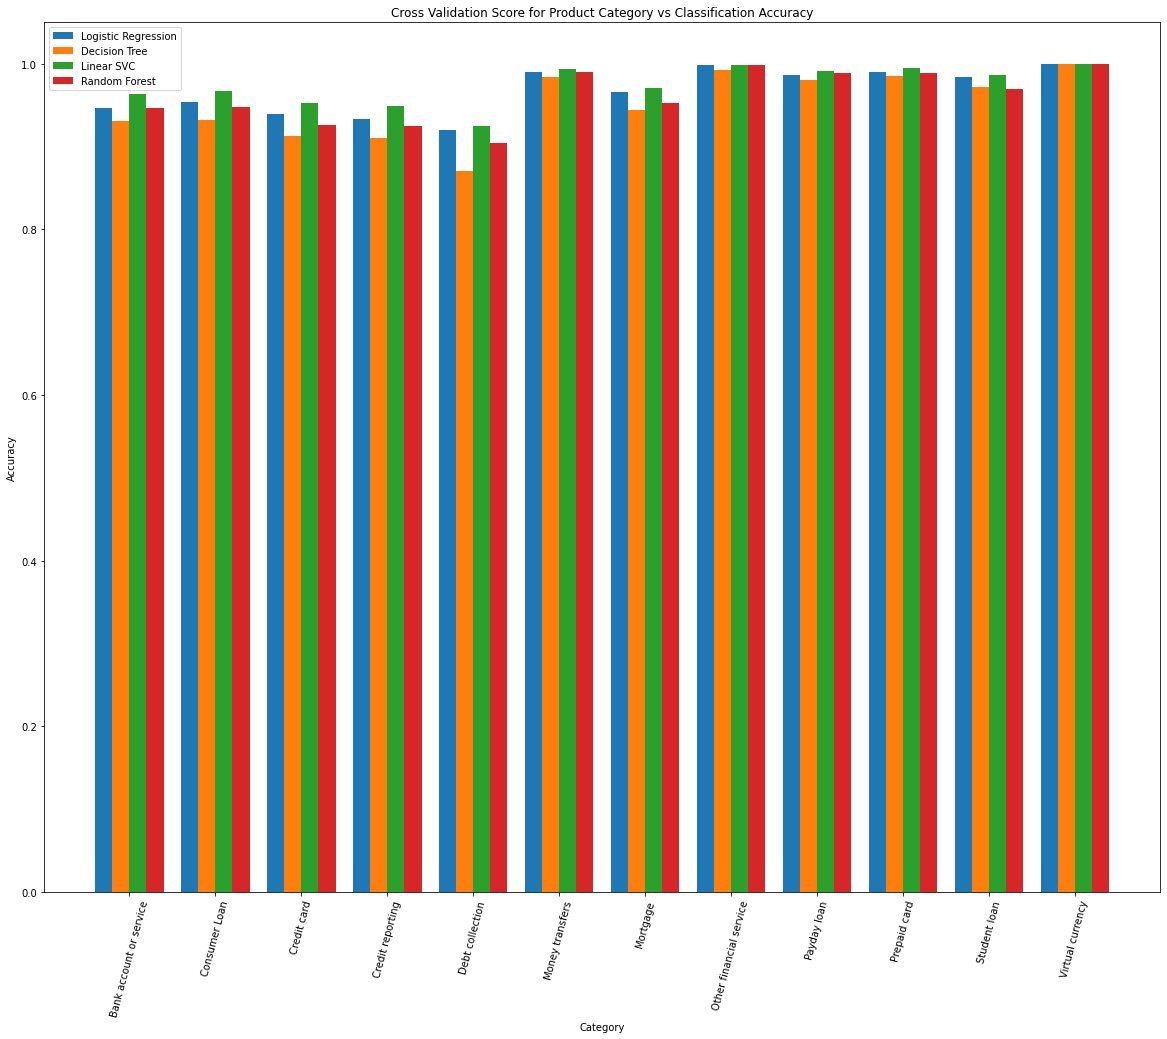

In [ ]:
lr=result_df[result_df['name']=='lr']
dt=result_df[result_df['name']=='decisiontree']
svm=result_df[result_df['name']=='svm']
rf=result_df[result_df['name']=='Random Forest']

x=np.arange(len(lr['Category']))

plt.figure(figsize=(20,16))
plt.bar(x,lr['CV Score'],label='Logistic Regression',width=0.2)
plt.bar(x+0.2,dt['CV Score'],label='Decision Tree',width=0.2)
plt.bar(x+0.4,svm['CV Score'],label='Linear SVC',width=0.2)
plt.bar(x+0.6,rf['CV Score'],label='Random Forest',width=0.2)
plt.legend()
plt.title('Cross Validation Score for Product Category vs Classification Accuracy')
plt.xlabel('Category')
plt.ylabel('Accuracy')
plt.xticks(x+0.3,labels=rf['Category'],rotation=75)
plt.show()

Though overall accuracy for all models is above 90%, this metric is unreliable as its imbalanced dataset. Higher Accuracy score must have contributed by Majority class. We need a metric which is relative to each class.

So, considering ***Precision and Recall metrics*** which is relative to each category class. 


In [ ]:
def train_predict_model(model):
  l=[]
  pc=[]
  y_score=pd.DataFrame()
  for class_name in y_train.columns:
    train_target = y_train[class_name]
    test_target = y_test[class_name]
    classifier=model
    classifier.fit(X_train,train_target)
    y_pred=classifier.predict(X_test)
    #pc.append(precision_recall_curve(test_target, y_pred))
    rs=recall_score(test_target,y_pred,average='binary')
    ps=precision_score(test_target,y_pred,average='binary')
    l.append({'Category':class_name,'Recall Score':rs,'Precision Score':ps})
    y_score[class_name]=y_pred
  return y_score, pd.DataFrame(l)
  #y_pred_prob = classifier._predict_proba_lr(X_test,y_test)[:, 1]
  #auc_score=metrics.roc_auc_score(test_target, y_pred_prob)
  #print(confusion_matrix(test_target,y_pred))
  #print(classification_report(test_target,y_pred))

**SVM - Precision Recall Measure**



In [ ]:
from sklearn.metrics import average_precision_score
t,p=train_predict_model(LinearSVC(class_weight='balanced'))
avg_ps_SVC=average_precision_score(y_test, t, average="micro")
print("Average Precision Recall: ","{:.2f}".format(avg_ps_SVC))
print("\n")
print(p)

Average Precision Recall:  0.73


                   Category  Recall Score  Precision Score
0   Bank account or service      0.790769         0.794845
1             Consumer Loan      0.603865         0.730994
2               Credit card      0.804054         0.785767
3          Credit reporting      0.877226         0.867068
4           Debt collection      0.886111         0.848686
5           Money transfers      0.660550         0.727273
6                  Mortgage      0.926909         0.933005
7   Other financial service      0.052632         1.000000
8               Payday loan      0.388430         0.691176
9              Prepaid card      0.677686         0.845361
10             Student loan      0.803797         0.875862
11         Virtual currency      1.000000         1.000000


**Logistic Regression - Precision Recall Measure**

In [ ]:
t,p=train_predict_model(LogisticRegression(solver='newton-cg',class_weight='balanced'))
avg_ps_SVC=average_precision_score(y_test, t, average="micro")
print("Average Precision Recall: ","{:.2f}".format(avg_ps_SVC))
print("\n")
print(p)

Average Precision Recall:  0.69


                   Category  Recall Score  Precision Score
0   Bank account or service      0.881026         0.647813
1             Consumer Loan      0.735910         0.551932
2               Credit card      0.873123         0.691028
3          Credit reporting      0.911434         0.797785
4           Debt collection      0.905208         0.817498
5           Money transfers      0.798165         0.488764
6                  Mortgage      0.940384         0.908123
7   Other financial service      0.210526         0.333333
8               Payday loan      0.677686         0.445652
9              Prepaid card      0.834711         0.570621
10             Student loan      0.871308         0.764815
11         Virtual currency      1.000000         1.000000


**Decision Tree Classifier - Precision Recall Measure**

In [ ]:
t,p=train_predict_model(DecisionTreeClassifier(class_weight='balanced'))
avg_ps_SVC=average_precision_score(y_test, t, average="micro")
print("Average Precision Recall: ","{:.2f}".format(avg_ps_SVC))
print("\n")
print(p)

Average Precision Recall:  0.56


                   Category  Recall Score  Precision Score
0   Bank account or service      0.701538         0.588134
1             Consumer Loan      0.524960         0.438172
2               Credit card      0.705706         0.633850
3          Credit reporting      0.812090         0.737761
4           Debt collection      0.802431         0.727645
5           Money transfers      0.504587         0.354839
6                  Mortgage      0.887709         0.866135
7   Other financial service      0.052632         0.011494
8               Payday loan      0.380165         0.272189
9              Prepaid card      0.520661         0.350000
10             Student loan      0.761603         0.679849
11         Virtual currency      1.000000         1.000000


**Random Forest Classifier - Precision Recall Measure**

In [ ]:
t,p=train_predict_model(RandomForestClassifier(class_weight='balanced'))
avg_ps_SVC=average_precision_score(y_test, t, average="micro")
print("Average Precision Recall: ","{:.2f}".format(avg_ps_SVC))
print("\n")
print(p)

Average Precision Recall:  0.61


                   Category  Recall Score  Precision Score
0   Bank account or service      0.442051         0.957778
1             Consumer Loan      0.075684         0.886792
2               Credit card      0.481982         0.927746
3          Credit reporting      0.722587         0.904930
4           Debt collection      0.752431         0.899917
5           Money transfers      0.027523         1.000000
6                  Mortgage      0.831768         0.959943
7   Other financial service      0.052632         1.000000
8               Payday loan      0.008264         1.000000
9              Prepaid card      0.033058         0.800000
10             Student loan      0.341772         0.975904
11         Virtual currency      0.000000         0.000000


In all the 4 chosen models, Precision and recall score was pretty descent for Mortgage, DebtCollection, Credit Card, Credit Reporting but poor for few categories.

Perhaps more data would have yielded better Recall score.

**Current highest average Recall score : 73%**. Lets beat this accuracy using other approaches

# **Method 2: As MultiClassification Problem with balancing weights**

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y)
print(X_train.shape,y_train.shape)

(44944, 237000) (44944,)


In [ ]:
def recall(y_true, y_pred, **kwargs):
  return recall_score(y_true,y_pred,average='micro')

myscore= make_scorer(recall,greater_is_better=True,average='micro')

In [ ]:
l=[]
models=[]
models.append(('Logistic Regression',LogisticRegression(multi_class='ovr',solver='liblinear')))
models.append(('Decision Tree',DecisionTreeClassifier(class_weight='balanced',random_state=45)))
models.append(('Linear SVC',LinearSVC(class_weight='balanced', verbose=False, max_iter=10000, tol=1e-4, C=0.1)))
models.append(('Random Forest',RandomForestClassifier(n_estimators=100,max_depth=100,min_samples_split=10,random_state=13,class_weight='balanced')))
for name,model in models:
  st_time = time.time()
  kfold=KFold(n_splits=5)
  cross_val_sc=cross_val_score(model,X_train,y_train,scoring=myscore,cv=kfold,error_score="raise")
  print(cross_val_sc)
  en_time = time.time()
  l.append({'Model':name,'Time Taken':en_time-st_time,'CV Recall Score':cross_val_sc.mean()})
df=pd.DataFrame(l,columns=['Model','Time Taken','CV Recall Score'])
df

[0.83201691 0.83068194 0.83134943 0.83958171 0.83489097]
[0.71665369 0.69963288 0.70730893 0.71754366 0.70160214]
[0.84848148 0.84814774 0.84247414 0.84670152 0.84690699]
[0.81310491 0.81099121 0.81232618 0.81321615 0.8106364 ]


,Model,Time Taken,CV Recall Score
0,Logistic Regression,122.252413,0.833704
1,Decision Tree,627.909602,0.708548
2,Linear SVC,19.721562,0.846542
3,Random Forest,547.392426,0.812055


Among 4 algorithms, **Logistic Regression and SVM** tops the list in terms of Recall Score. Decision Tree and Random Forest took more Execution time.

CV score is 84% using Linear SVC. Can we do better?

**SVC class using RBF kernel to improve accuracy**

In [ ]:
from sklearn.svm import SVC
cls=SVC(gamma='scale',kernel="rbf")
cls.fit(X_train,y_train)
y_pred=cls.predict(X_test)
recall_score(y_test,y_pred,average='micro')

0.8438056247775009

**Hyperparameter tuning for SVC**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

In [ ]:
svm_clf = SVC(gamma="scale",kernel="rbf")
param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_cv.fit(X_train[:10000], y_train[:10000])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ...C=1.6111567544099106, gamma=0.002230769245601673; total time= 1.0min
[CV] END ...C=1.6111567544099106, gamma=0.002230769245601673; total time=  56.0s
[CV] END ...C=1.6111567544099106, gamma=0.002230769245601673; total time=  56.9s
[CV] END .....C=10.4817603130781, gamma=0.054293154651838565; total time=  56.2s
[CV] END .....C=10.4817603130781, gamma=0.054293154651838565; total time=  47.1s
[CV] END .....C=10.4817603130781, gamma=0.054293154651838565; total time=  47.2s
[CV] END ...C=6.777244973774006, gamma=0.0027405711769610836; total time=  58.6s
[CV] END ...C=6.777244973774006, gamma=0.0027405711769610836; total time=  58.1s
[CV] END ...C=6.777244973774006, gamma=0.0027405711769610836; total time=  57.9s
[CV] END .....C=2.872845479437828, gamma=0.03447972181669906; total time=  49.4s
[CV] END .....C=2.872845479437828, gamma=0.03447972181669906; total time=  49.7s
[CV] END .....C=2.872845479437828, gamma=0.03447

RandomizedSearchCV(cv=3, estimator=SVC(),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8d08ba5650>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8d08b9dc50>},
                   verbose=2)

In [ ]:
rnd_search_cv.best_estimator_

SVC(C=10.4817603130781, gamma=0.054293154651838565)

In [ ]:
rnd_search_cv.best_score_

0.8124003462133856

Recall Score: 0.8512815948736205
Accuracy Score: 0.8512815948736205
                         precision    recall  f1-score   support

Bank account or service       0.81      0.80      0.81       975
               Mortgage       0.79      0.62      0.70       621
        Debt collection       0.81      0.84      0.83      1332
          Consumer Loan       0.86      0.87      0.86      2134
            Credit card       0.82      0.89      0.86      2880
       Credit reporting       0.75      0.55      0.63       108
            Payday loan       0.93      0.94      0.94      2449
           Student loan       0.00      0.00      0.00        19
        Money transfers       0.68      0.23      0.35       121
           Prepaid card       0.81      0.65      0.72       122
Other financial service       0.91      0.79      0.85       474
       Virtual currency       0.00      0.00      0.00         1

               accuracy                           0.85     11236
              macro 

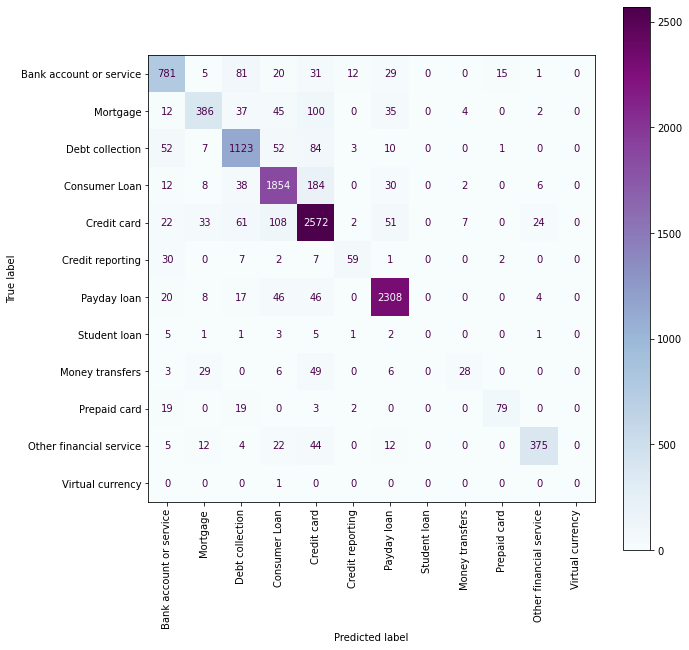

In [ ]:
labels=text_modelling_df['Product'].unique()

rnd_search_cv.best_estimator_.fit(X_train, y_train)
y_pred=rnd_search_cv.best_estimator_.predict(X_test)

print("Recall Score:",recall_score(y_test,y_pred,average='micro'))
print("Accuracy Score:",accuracy_score(y_test,y_pred))

print(classification_report(y_test,y_pred,target_names=labels))
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(rnd_search_cv.best_estimator_,X_test,y_test,display_labels=labels, xticks_rotation='vertical', cmap="BuPu",ax=ax)

Even after doing Hyper parameter tuning using Kernels in SVM, just 1% improvement in accuracy

# **PERFORMANCE COMPARISON**

There were 2 approaches to predict Product category from Consumer Complaint Narrative. <br>
* **METHOD:1** Problem Transformation as Binary Classification.<br>

Model | Accuracy Score
--- | ---
Linear SVC | 73%
Logistic Regression | 69%
Random Forest | 61%
Decision Tree | 56%
<br>

* **METHOD:2** As a MultiClassification Problem <br>

Model | Accuracy Score
--- | ---
Linear SVC | 85%
Logistic Regression | 83.4%
Random Forest | 81.20%
Decision Tree | 70%



**CONCLUSION:**  As First approach, I transformed multi class classification problem into Binary classification and predicted each category Class independently using Linear SVC, Logistic Regression,Decision Tree and Random Forest Classifier. Overall Accuracy was above 90% in those methods that score is predominantly contributed by majority class data. Due to imbalanced dataset decided to choose a metric which is relative to both the classes. So chosen to check Precision Recall score which was 73% as highest. There was room for improvement of Recall score.
Then As a second Approach, retained target variable with multi category classes and used same algorithms chosen in the 1st approach and to balance the classes, provided class_weight= balanced which yeilded highest Recall score as 83%. To further improve the metric decided to use SVC class from SVM algorithm with kernel and performed hyperparameter tuning for SVC parameters (C and gamma) which gave 85% accuracy. Finally algorithm SVC using RBF kernel along with best values for hyperparameters yielded **85%** accuracy